<a href="https://colab.research.google.com/github/FrancisKurian/CS530/blob/main/CS530_hw13_finals_nfl_first_pick_prediction_panel_data_KS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediction of First-Round Picks based on the Player Performance after the Drafting

### Notes on data preperation
* Panel data with multiple years performance for a player post drafting.first, average, sum and max of various performance metrics were considered for each player. 
* categorical variables like position, team needed one-hot encoding.
* ordinal variables like height was converted from categorical to ordinal.
* Binning was explored for features with top information value(IV) and re-grouping was done based on weight of evidence(WoE).  
* * 'Information Value and Weight of evidence Calculation for feature engineering' section details this excercise.
* Scaling of features 

* Correlation matrix for features was created. Stepwise removal of features done to simplify the list of features without compromising performance.Overall, classification algorithms are tolerent of correlated features.

### Notes on Model Evaluation Metric
* Data is unbalanced. Only 10% of the training data was 'first-time picks' or target. Accuracy or ROC-AUC will be an incorrect metric to compare various classification algorithms. Instead three following metrics were used to evaluate various models.  
>* Precision-Recall AUC  
>* K-S statistics (Kolmogorov–Smirnov test). Measures the degree of seperation between True Positives(TP) and False Positives(FP) at various probability thresholds.
>* Recall Rate (True Positive Rates)

### Notes on Modeling Process
* 5 classification algorithms were tested with hyperparmeter tuning using GridSearchCV and k-fold validations.
* Logistics regression and XGB Classifiers were further tuned for unbalanced data.
* K-S statistics was used to identify the optimal probability threshold to identify 'first-time picks'. Used Recall Rate to pick the best predictor with the assumption of minimum cost for flase negatives.

### Summary of Results.
K-S driven probability thresholds were very effective in all algorithms to achieve a higher recall rate. Logistics regression model with ‘balanced’ weight regularization and Gradient Boosting algorithm (XGBoost) with unbalanced hyperparameter emerged as the best model in separating 'first-round pick’ from the rest of the players

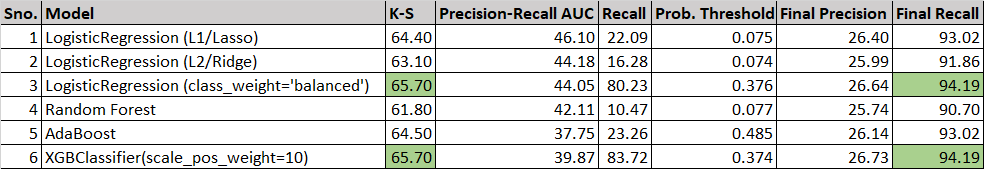

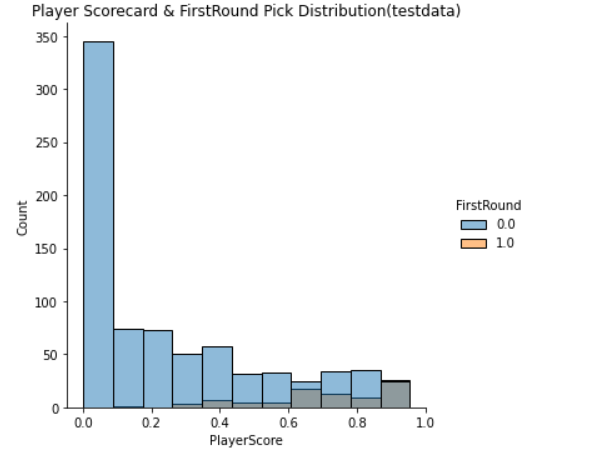

## Interpretation of the model results
Distribution of players by their probability score is a better way to visualize how well the model discriminate the minority target class (First-round pick) from the majority class. Goal here is to separate the First-round picks from the rest. The majority class is large so a high accuracy does not tell how minority class can be picked using the model. The model assigns a probability to each player based on the given performance and with a K-S of 65.7, and given the probability threshold of 0.374, the model could capture 94% of the first-round picks by looking at just 35% of the players. In other words, 65% of the players can be rejected by setting player probability to a cut-off of 0.374 and the loss (failure to identify the first-round pick) will be just 6%. By adjusting the probability upwards, we could optimize this review exercise based on the resources. For example, by setting 0.71 as probability threshold, we can subset 15% of the players and out of which, 55% will be first-round picks. Detailed Trade-off curve/table is provided in the K-S section of the analysis in Jupyter notebook.
 

## Libraries Used

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc,matthews_corrcoef,f1_score, accuracy_score, confusion_matrix,precision_score, recall_score,precision_recall_curve
from matplotlib import pyplot as plt

In [3]:
from google.colab import files
uploaded = files.upload()

Saving final_nfl_test.csv to final_nfl_test.csv
Saving final_nfl_train.csv to final_nfl_train.csv


## Data Preperation, Features Engineering and  step-wise evaluation of performance metrics 
* Information value and Weight of Evidence based features engineering(see data exploration section)
* Ordinal features treatment
* Experimenting first, mean, sum, max of panel data by Player ID.(except for features like age, hight)
* Dummy variables for position, team , fantacy points groups (IV based)  

In [4]:
def prep(df,dlist,agg_type):
  df = df.sort_values(['PlayerID', 'Year'])

# first and max observation of most sgnificant feature

  df_f = df.groupby('PlayerID').agg('first')
  df_max = df.groupby('PlayerID').agg('max')

  df_f = df_f[['FPoints']]
  df_f=df_f.rename(columns={"FPoints": "FPointsFirst"})
  df_max = df_max[['FPoints']]
  df_max=df_max.rename(columns={"FPoints": "FPointsMax"})

# Sum of features with top information value

  df_sum=df.groupby(['PlayerID'])[['FPoints','Penalty','PenaltyYds','Assist','Tackle','FumRec','TFL','PassDef','Sack','FrcFum','QBHit']].sum()
  df_sum.columns = ['FPoints_sum',	'Penalty_sum',	'PenaltyYds_sum',	'Assist_sum',	'Tackle_sum',	'FumRec_sum',	'TFL_sum',	'PassDef_sum',	'Sack_sum',	'FrcFum_sum',	'QBHit_sum']

  df_last = df.groupby('PlayerID').agg('last')
  df_mean = df.groupby('PlayerID').agg(agg_type)
  df_last_cats = df_last.loc[:,['Position','Name','Height','Team']]
  df_full = df_mean.join(df_f).join(df_max).join(df_sum).join(df_last_cats).reset_index()
 

  ordinal_encoding = {'Height': {np.nan: 0, '5-5': 1, '5-6': 2, '5-7': 3, '5-8': 4, '5-9': 5, '5-10': 6, '5-11': 7, '6-0': 8, 
                                '6-1': 9, '6-2': 10,'6-3': 11,'6-4': 12,'6-5': 13,'6-6': 14,'6-7': 15,'6-8': 16,'6-9': 17},
                      'DraftYear': {np.nan: 0}}
  df_full.replace(ordinal_encoding, inplace=True)

  df_full['Position'].replace({'OL' : 'Rare_var','HB' : 'Rare_var'},inplace=True)
  
  # binning based on weight of evidence
  df_full['FPointsGrp'] = pd.cut(df_full.FPointsFirst, [-100, 13.125, 37.25, np.inf], labels=['Grp1', 'Grp2', 'Grp3'])
  df_full=df_full.drop(dlist, axis=1)

  # dropping highly correlated variables -last 4 features
  # dlist = ['Name','Year','FPoints', 'FPointsMax','Sack','Tackle'] 

  df_full = pd.get_dummies(df_full, columns=['Position', 'Team','FPointsGrp'])
  # df_full = pd.get_dummies(df_full, columns=[ 'Team', 'FPointsGrp'])
  print(df_full.shape)

  return df_full

df = pd.read_csv("final_nfl_train.csv")
df_t = pd.read_csv("final_nfl_test.csv")
df['FirstRound'] = (df['Pick'] <= 32)*1
df=df.drop(['Pick'], axis=1)
dlist = ['Name','Year','FPointsFirst','FPoints_sum',	'Penalty_sum',	'PenaltyYds_sum',	'Assist_sum',	'Tackle_sum',	'FumRec_sum',	'TFL_sum',	'PassDef_sum',	'Sack_sum',	'FrcFum_sum',	'QBHit_sum']
df_full= prep(df,dlist,'mean')
df_t= prep(df_t,dlist,'mean')


(8677, 124)
(965, 123)


### Training/Test Splits, Scaling

In [5]:
X=df_full.drop(['PlayerID','FirstRound'], axis=1)
scaled_features = StandardScaler().fit_transform(X.values)
scaled_features_df = pd.DataFrame(scaled_features, index=X.index, columns=X.columns)
X_train, X_test, y_train, y_test = train_test_split(scaled_features_df,df_full['FirstRound'],test_size=0.1,random_state=1234)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7809, 122), (7809,), (868, 122), (868,))

## Evaluate Various Algorithms-Find the Probability Threshold based on K-S statistic
* Train varioius algorithims and validate on test data.
* List K-S statistics, Precision-Recall AUC to compare the model improvement
* Identify the probability threshold based on K-S (TP/FP) and recalculate confusion matrix, recall and precision. 
* Pick the best model that seperates minority class, within tolerences. 

### List of algorithms - Hyperparameters are arrived using GridSearch
* see data exploration section for Gridsearch set-up 

In [6]:
models = list()
models.append(LogisticRegression(C=0.08685113737513521, max_iter=5000,penalty='l1', solver='liblinear'))
# models.append(LogisticRegression(class_weight='balanced',C=0.08685113737513521, max_iter=5000,penalty='l1', solver='liblinear'))
models.append(LogisticRegression(C=0.004291934260128779,  max_iter=5000,penalty='l2', solver='sag'))
models.append(LogisticRegression(class_weight='balanced',max_iter=5000)) # inblanced class hyperparameter
models.append(RandomForestClassifier(max_depth=7, n_estimators=200, random_state=42))
# models.append(KNeighborsClassifier(n_neighbors=4))
models.append(AdaBoostClassifier())
# models.append(BaggingClassifier(n_estimators=10))
# models.append(XGBClassifier(eval_metric='mlogloss'))
models.append(XGBClassifier(scale_pos_weight=10,eval_metric='mlogloss')) # negative- positive ratio 90:10 

In [7]:
def evaluate_models(X, y, models,X_test,y_test):
    for model in models:
        clf=model.fit(X,y)
        y_pred=clf.predict(X_test) 
        probs = model.predict_proba(X_test)[:,1]
        precision, recall, _ = precision_recall_curve(y_test, probs)
        auc_score = auc(recall, precision)
        acc = accuracy_score(y_test,  y_pred)
        mcc=matthews_corrcoef(y_test, y_pred)
       
        prediction = pd.DataFrame( y_pred, columns = ['prediction'])
        prediction.insert(1, 'Test',y_test.to_frame())
        prediction['PlayerScore'] = probs
        mydf = ks(data=prediction,target="Test", prob="PlayerScore")
        print(model.__class__.__name__,"K-S Statistics", mydf.KS.max())

        print('Precision-Recall AUC','%s: %.2f' % (model.__class__.__name__, auc_score*100))
        print('Matthews Correlation Coef.','%s: %.2f' % (model.__class__.__name__, mcc*100))
        
        print('Precision:','%.2f' % ( precision_score(y_test, y_pred)*100))
        print('Recall:','%.2f' % (recall_score(y_test, y_pred)*100))
        print('Confusion Matrix:\n',confusion_matrix(y_test, y_pred))

        print('-------Adjusted Probability Threshold based on K-S--------')
        threshold=np.round(mydf.loc[mydf.KS == mydf.KS.max(), 'min_prob'].values,4)[0]
        y_pred2 = np.where(model.predict_proba(X_test)[:, 1] >= threshold, 1, 0)
        print('Probability Threshold:','%.4f' % (threshold))
        print('Precision:','%.2f' % ( precision_score(y_test, y_pred2)*100))
        print('Recall:','%.2f' % (recall_score(y_test, y_pred2)*100))
        print('Confusion Matrix:\n',confusion_matrix(y_test, y_pred2))
        print('*********************************************************************')
    return mydf,threshold

### Function that calculates K-S (Kolmogorov–Smirnov test) Statistics
source: https://www.listendata.com/2019/07/KS-Statistics-Python.html

In [ ]:
!pip install colorama
def ks(data=None,target=None, prob=None):
    data['target0'] = 1 - data[target]
    data['bucket'] = pd.qcut(data[prob], 20)
    grouped = data.groupby('bucket', as_index = False)
    kstable = pd.DataFrame()
    kstable['min_prob'] = grouped.min()[prob]
    kstable['max_prob'] = grouped.max()[prob]
    kstable['events']   = grouped.sum()[target]
    kstable['nonevents'] = grouped.sum()['target0']
    kstable = kstable.sort_values(by="min_prob", ascending=False).reset_index(drop = True)
    kstable['event_rate'] = (kstable.events / data[target].sum()).apply('{0:.2%}'.format)
    kstable['nonevent_rate'] = (kstable.nonevents / data['target0'].sum()).apply('{0:.2%}'.format)
    kstable['cum_eventrate']=(kstable.events / data[target].sum()).cumsum()
    kstable['cum_eventr']=(kstable.events / data[target].sum()).cumsum()
    kstable['cum_noneventrate']=(kstable.nonevents / data['target0'].sum()).cumsum()
    kstable['cum_noneventr']=(kstable.nonevents / data['target0'].sum()).cumsum()
    kstable['KS'] = np.round(kstable['cum_eventrate']-kstable['cum_noneventrate'], 3) * 100

    #Formating
    kstable['cum_eventrate']= kstable['cum_eventrate'].apply('{0:.2%}'.format)
    kstable['cum_noneventrate']= kstable['cum_noneventrate'].apply('{0:.2%}'.format)
    kstable.index = range(1,21)
    kstable.index.rename('Decile', inplace=True)
    # pd.set_option('display.max_columns', 9)
    # print(kstable)
    
    #Display KS
    from colorama import Fore
    # print(Fore.RED + "KS is " + str(max(kstable['KS']))+"%"+ " at decile " + str((kstable.index[kstable['KS']==max(kstable['KS'])][0])))
    # print(Fore.RED + "KS is " + str(max(kstable['KS']))+"%"+ " at decile " + str((kstable.index[kstable['KS']==max(kstable['KS'])][0])))
    return(kstable)

In [10]:
mydf,threshold=evaluate_models(X_train,y_train,models,X_test,y_test)

LogisticRegression K-S Statistics 64.4
Precision-Recall AUC LogisticRegression: 46.10
Matthews Correlation Coef. LogisticRegression: 31.07
Precision: 55.88
Recall: 22.09
Confusion Matrix:
 [[767  15]
 [ 67  19]]
-------Adjusted Probability Threshold based on K-S--------
Probability Threshold: 0.0749
Precision: 26.32
Recall: 93.02
Confusion Matrix:
 [[558 224]
 [  6  80]]
*********************************************************************
LogisticRegression K-S Statistics 63.1
Precision-Recall AUC LogisticRegression: 44.17
Matthews Correlation Coef. LogisticRegression: 26.57
Precision: 56.00
Recall: 16.28
Confusion Matrix:
 [[771  11]
 [ 72  14]]
-------Adjusted Probability Threshold based on K-S--------
Probability Threshold: 0.0737
Precision: 25.99
Recall: 91.86
Confusion Matrix:
 [[557 225]
 [  7  79]]
*********************************************************************
LogisticRegression K-S Statistics 65.7
Precision-Recall AUC LogisticRegression: 44.05
Matthews Correlation Coef.

## Final Model

In [11]:
model=XGBClassifier(scale_pos_weight=10,eval_metric='mlogloss')
model.fit(X_train, y_train)
probs = model.predict_proba(X_test)[:,1]
y_pred = np.where(model.predict_proba(X_test)[:, 1] >= threshold, 1, 0)
print(model.__class__.__name__,"K-S Statistics", mydf.KS.max())
print('Precision:','%.2f' % ( precision_score(y_test, y_pred)*100))
print('Recall:','%.2f' % (recall_score(y_test, y_pred)*100))
print('Confusion Matrix:\n',confusion_matrix(y_test, y_pred))
pd.DataFrame(data = y_pred, columns = ['FirstRound']).to_csv('training_nfl_prediction__kurian.csv')

XGBClassifier K-S Statistics 65.7
Precision: 26.73
Recall: 94.19
Confusion Matrix:
 [[560 222]
 [  5  81]]


Text(0.5, 1.0, 'Player Scorecard & FirstRound Pick Distribution(testdata)')

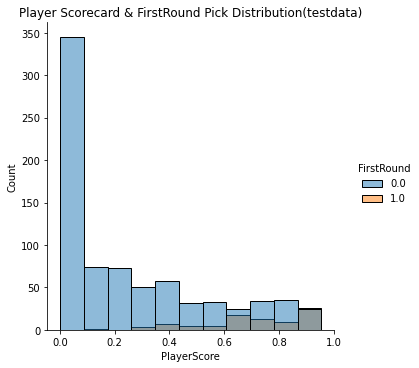

In [16]:
validation = pd.DataFrame(data = y_test, columns = ['FirstRound'])
validation['PlayerScore'] = probs
sns.displot(validation, x="PlayerScore", hue="FirstRound")
plt.title("Player Scorecard & FirstRound Pick Distribution(testdata)")

##  K-S Statistics : Seperatation of Monority (Positive) and Majority Classes

### The chart shows how well the model seperates minority class (TP) from Majority class . The K-S statistics is where the degree of seperation is highest (Blue Line). The probability at this threshold provides the best precision/recall.

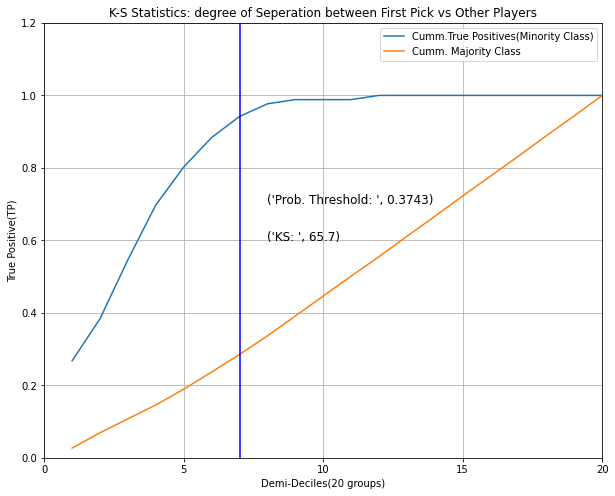

In [11]:
plt.rcParams["figure.figsize"] = (10,8)
df_ks=mydf.copy()
df_ks['decile'] =mydf.index
decile=df_ks.loc[df_ks.KS == df_ks.KS.max()].decile.values[0]
sns.lineplot(data=df_ks,  x='decile', y="cum_eventr",label='Cumm.True Positives(Minority Class)' )
sns.lineplot(data=df_ks,  x='decile', y="cum_noneventr",label='Cumm. Majority Class' )
plt.ylim(0, 1.2)
plt.xlim(0, 20)
plt.axvline(x = decile, color = 'b', label = 'axvline - full height')
plt.grid()
plt.xticks(np.arange(0, 21, 5))

plt.title("K-S Statistics: degree of Seperation between First Pick vs Other Players")
plt.ylabel("True Positive(TP)")
plt.xlabel("Demi-Deciles(20 groups)")
plt.text(8, .6, ('KS: ',df_ks.KS.max()), fontsize = 12)
plt.text(8, .7, ('Prob. Threshold: ',threshold), fontsize = 12)
plt.show()

### K-S computation, Demi-Decile group by probability ranges. 

In [12]:
df_ks

,min_prob,max_prob,events,nonevents,event_rate,nonevent_rate,cum_eventrate,cum_eventr,cum_noneventrate,cum_noneventr,KS,decile
Decile,,,,,,,,,,,,
1,0.876595,0.955539,23.0,21.0,26.74%,2.69%,26.74%,0.267442,2.69%,0.026854,24.1,1
2,0.803173,0.876566,10.0,33.0,11.63%,4.22%,38.37%,0.383721,6.91%,0.069054,31.5,2
3,0.710499,0.801694,14.0,30.0,16.28%,3.84%,54.65%,0.546512,10.74%,0.107417,43.9,3
4,0.625139,0.709731,13.0,30.0,15.12%,3.84%,69.77%,0.697674,14.58%,0.145780,55.2,4
5,0.529045,0.625077,9.0,34.0,10.47%,4.35%,80.23%,0.802326,18.93%,0.189258,61.3,5
6,0.429152,0.527221,7.0,37.0,8.14%,4.73%,88.37%,0.883721,23.66%,0.236573,64.7,6
7,0.374293,0.425305,5.0,38.0,5.81%,4.86%,94.19%,0.941860,28.52%,0.285166,65.7,7
8,0.303924,0.373443,3.0,40.0,3.49%,5.12%,97.67%,0.976744,33.63%,0.336317,64.0,8
9,0.243927,0.302422,1.0,43.0,1.16%,5.50%,98.84%,0.988372,39.13%,0.391304,59.7,9


## Prediction of given dataset and final file creation

In [12]:
df_t2=df_t.drop(['PlayerID'], axis=1)
df_t_scaled = StandardScaler().fit_transform(df_t2.values)
test = pd.DataFrame(df_t_scaled, index=df_t2.index, columns=df_t2.columns)
test.shape

(965, 122)

In [13]:
print('Model:',model.__class__.__name__)
print('probability threshold:',threshold)

Model: XGBClassifier
probability threshold: 0.3743


In [14]:
y_pred = np.where(model.predict_proba(test)[:, 1] >= threshold, 1, 0)
prediction = pd.DataFrame(data = y_pred, columns = ['FirstRound'])
prediction.insert(0, 'PlayerID',df_t['PlayerID'].values)
prediction.head(5)

,PlayerID,FirstRound
0,00-0000008,1
1,00-0000100,0
2,00-0000129,1
3,00-0000313,0
4,00-0000387,1


In [16]:
prediction.to_csv('final_nfl_prediction_kurian.csv', index = False, header = True)

## Summary of Model performance

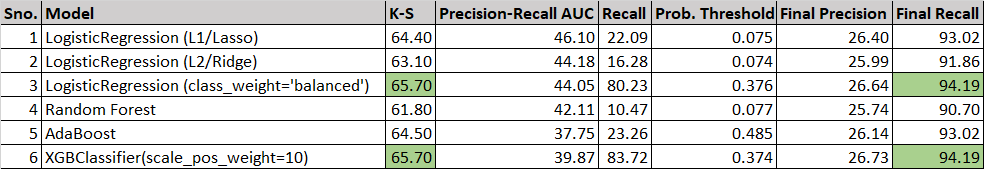

# Appendix: Preliminary Data Exploration,modeling, diagnostics

In [169]:
df = pd.read_csv("final_nfl_train.csv")
df_t = pd.read_csv("final_nfl_test.csv")

### Sort dataset by PlayerID and Year to extract, first record accurately.

In [170]:
df = df.sort_values(['PlayerID', 'Year'])

### The FantasyPoints column is a linear combination of other stats so keep the first and max along with average

In [171]:
df_f = df.groupby('PlayerID').agg('first')
df_max = df.groupby('PlayerID').agg('max')

df_f = df_f[['FPoints']]
df_f=df_f.rename(columns={"FPoints": "FPointsFirst"})
df_max = df_max[['FPoints']]
df_max=df_max.rename(columns={"FPoints": "FPointsMax"})

### Panel data to single record, with average of statistics

In [172]:
df_last = df.groupby('PlayerID').agg('last')
df_mean = df.groupby('PlayerID').agg('mean')
df_last_cats = df_last.loc[:,['Position','Name','Height','Team']]
# df_full = df_mean.join(df_last_cats).reset_index()
df_full = df_mean.join(df_f).join(df_max).join(df_last_cats).reset_index()
df_full['FirstRound'] = (df_full['Pick'] <= 32)*1
df_we =df_full.copy()
df2 =df_full.copy()

In [ ]:
df_full.head()

In [ ]:
categorical_features=[feature for feature in df_full.columns if df_full[feature].dtype=='O']
for feature in categorical_features:
    print((df_full[feature].value_counts()))

In [175]:
ordinal_encoding = {'Height': {np.nan: 0, '5-5': 1, '5-6': 2, '5-7': 3, '5-8': 4, '5-9': 5, '5-10': 6, '5-11': 7, '6-0': 8, 
                               '6-1': 9, '6-2': 10,'6-3': 11,'6-4': 12,'6-5': 13,'6-6': 14,'6-7': 15,'6-8': 16,'6-9': 17},
                    'DraftYear': {np.nan: 0}}
df_full.replace(ordinal_encoding, inplace=True)

In [176]:
df_full['Position'].replace({'OL' : 'Rare_var','HB' : 'Rare_var'},inplace=True)
# df_full['Height'].replace({'5-5' : 'Rare_var','6-9' : 'Rare_var','5-6' : 'Rare_var'},inplace=True)
df_full=df_full.drop(['Pick','Name','Year'], axis=1)

In [ ]:
categorical_features=[feature for feature in df_full.columns if df_full[feature].dtype=='O']
for feature in categorical_features:
    print((df_full[feature].value_counts()))

In [ ]:
df_full.head()

In [179]:
df_full = pd.get_dummies(df_full, columns=['Position', 'Team'])
df_full.shape

(8677, 122)

In [ ]:
df_full.head()

In [181]:
from sklearn.preprocessing import StandardScaler
X=df_full.drop(['PlayerID','FirstRound'], axis=1)
scaled_features = StandardScaler().fit_transform(X.values)
scaled_features_df = pd.DataFrame(scaled_features, index=X.index, columns=X.columns)
# scaled_features_df=X.copy()

In [ ]:
scaled_features_df.head()

In [183]:
X_train, X_test, y_train, y_test = train_test_split(scaled_features_df,df_full['FirstRound'],test_size=0.1,random_state=1234)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7809, 120), (7809,), (868, 120), (868,))

### Principal Components Analysis

In [185]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
pca.fit(scaled_features)
print(pca.explained_variance_ratio_)

[0.10298581 0.06331812 0.05239072 0.04728804]


 No much scope with PCA- so continue with conventional approach

In [204]:
logr = LogisticRegression(random_state=0,max_iter=2000).fit(X_train, y_train)
y_pred=logr.predict(X_test) 
ac_lr=logr.score(X_test, y_test)
mc_lr=matthews_corrcoef(y_test, y_pred)
print(f'The accuracy of Logistic Regression : {ac_lr:.5}')
print(f'Mattews Correlation Coefficient is: {mc_lr:.5}')

probs = logr.predict_proba(X_test)[:,1]
fpr_lg_l1, tpr_lg_l1, threshs_lg_l1 = roc_curve(y_test, probs)
roc_auc_lg_l1 = auc(fpr_lg_l1, tpr_lg_l1)
print(f'ROC-Area Under the Curve(AUC) is: {roc_auc_lg_l1:.5}')
print('Precision:','%.2f' % ( precision_score(y_test, y_pred)*100))
print('Recall:','%.2f' % (recall_score(y_test, y_pred)*100))
confusion_matrix(y_test, y_pred)

The accuracy of Logistic Regression : 0.89977
Mattews Correlation Coefficient is: 0.28175
ROC-Area Under the Curve(AUC) is: 0.88626
Precision: 48.72
Recall: 22.09


array([[762,  20],
       [ 67,  19]])

In [205]:
rf = RandomForestClassifier(max_depth=30,n_estimators=300, min_samples_leaf=2,min_samples_split=20,criterion='entropy', oob_score=True,random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
mc_sk_income_rf=matthews_corrcoef(y_test, y_pred)
print(f'Accuracy of SKLearn Random Forest: {rf.score(X_test, y_test):.5}')
print(f'Matthews Coefficient for SKLearn Random Forest: {mc_sk_income_rf:.5}')

probs = rf.predict_proba(X_test)[:,1]
fpr_rf_l1, tpr_rf_l1, threshs_rf_l1 = roc_curve(y_test, probs)
roc_auc_rf_l1 = auc(fpr_rf_l1, tpr_rf_l1)
print(f'ROC-Area Under the Curve(AUC) is: {roc_auc_rf_l1:.5}')
print('Precision:','%.2f' % ( precision_score(y_test, y_pred)*100))
print('Recall:','%.2f' % (recall_score(y_test, y_pred)*100))
confusion_matrix(y_test, y_pred)

Accuracy of SKLearn Random Forest: 0.90783
Matthews Coefficient for SKLearn Random Forest: 0.29
ROC-Area Under the Curve(AUC) is: 0.88191
Precision: 63.64
Recall: 16.28


array([[774,   8],
       [ 72,  14]])

### Logistics - Unbalanced hyperparameter

In [206]:
logr = LogisticRegression(class_weight='balanced',random_state=0,max_iter=2000).fit(X_train, y_train)
y_pred=logr.predict(X_test) 
ac_lr=logr.score(X_test, y_test)
mc_lr=matthews_corrcoef(y_test, y_pred)
print(f'The accuracy of Logistic Regression : {ac_lr:.5}')
print(f'Mattews Correlation Coefficient is: {mc_lr:.5}')

probs = logr.predict_proba(X_test)[:,1]
fpr_lg_l1, tpr_lg_l1, threshs_lg_l1 = roc_curve(y_test, probs)
roc_auc_lg_l1 = auc(fpr_lg_l1, tpr_lg_l1)
print(f'ROC-Area Under the Curve(AUC) is: {roc_auc_lg_l1:.5}')
print('Precision:','%.2f' % ( precision_score(y_test, y_pred)*100))
print('Recall:','%.2f' % (recall_score(y_test, y_pred)*100))
confusion_matrix(y_test, y_pred)

The accuracy of Logistic Regression : 0.79954
Mattews Correlation Coefficient is: 0.42126
ROC-Area Under the Curve(AUC) is: 0.88936
Precision: 30.87
Recall: 82.56


array([[623, 159],
       [ 15,  71]])

### This looks great with a significant lift in True Positives

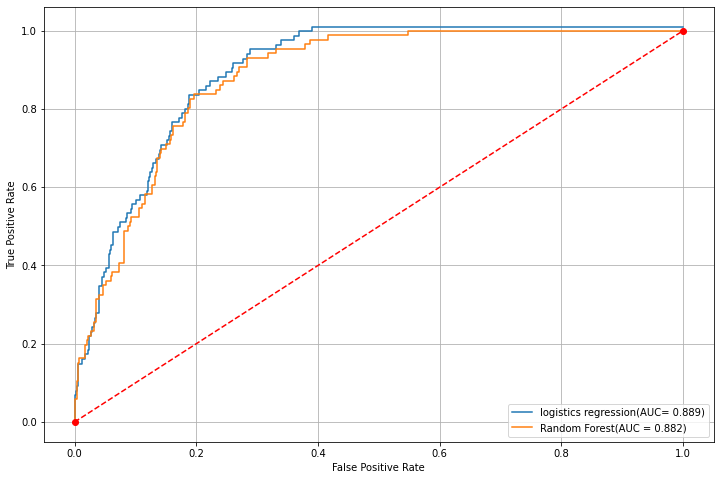

In [203]:
plt.rcParams["figure.figsize"] = (12,8)
plt.plot(fpr_lg_l1, tpr_lg_l1+0.01,label="logistics regression(AUC= %0.3f)" % roc_auc_lg_l1)
plt.plot(fpr_rf_l1, tpr_rf_l1, label="Random Forest(AUC = %0.3f)" % roc_auc_rf_l1)
plt.plot([0, 1], [0, 1], '--or')
plt.grid()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")

## Information Value and Weight of evidence Calculation for feature engineering

Reference: https://stackoverflow.com/questions/60892714/how-to-get-the-weight-of-evidence-woe-and-information-value-iv-in-python-pan

In [ ]:
def iv_woe(data, target, bins=10, show_woe=False):
    
    #Empty Dataframe
    newDF,woeDF = pd.DataFrame(), pd.DataFrame()
    
    #Extract Column Names
    cols = data.columns
    
    #Run WOE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()
        d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
        d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
        d.insert(loc=0, column='Variable', value=ivars)
        # print("Information value of " + ivars + " is " + str(round(d['IV'].sum(),6)))
        temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0)
        woeDF=pd.concat([woeDF,d], axis=0)

        #Show WOE Table
        if show_woe == True:
            print(d)
    return newDF, woeDF

### Extract Information Value- Predictive power in every input feature, Rank order the top 20

In [ ]:
# df_we =df_full.copy()
drop = ['PlayerID','DraftYear','Name','Pick','Year' ] 
df_we.drop(drop, axis=1, inplace=True)
iv, woe = iv_woe(data = df_we, target = 'FirstRound', bins=5, show_woe = False)
iv = iv.sort_values(['IV'], ascending=False)
iv=iv.head(20)
iv = iv.reset_index()  

In [ ]:
iv

,Variable,IV
0,FPointsFirst,0.680406
0,FPoints,0.672546
0,Penalty,0.581276
0,PenaltyYds,0.505883
0,FPointsMax,0.494517
0,Position,0.428999
0,Assist,0.361708
0,Tackle,0.358948
0,FumRec,0.317578
0,TFL,0.263476


In [ ]:
sig_variables =[]
for index, row in iv.iterrows():
    sig_variables.append(row['Variable'])
sig_variables.append('FirstRound')
df_we = df_we[sig_variables]

### Print Weight of Evidece for top 20 features to understand the scope of features engineering

In [ ]:
iv, woe = iv_woe(data = df_we, target = 'FirstRound', bins=5, show_woe = True)

       Variable           Cutoff     N  Events  % of Events  Non-Events  \
0  FPointsFirst  (-17.201, 0.75]  1789     132     0.155477        1657   
1  FPointsFirst    (0.75, 3.994]  1682      45     0.053004        1637   
2  FPointsFirst  (3.994, 13.125]  1737      70     0.082450        1667   
3  FPointsFirst  (13.125, 37.25]  1734     196     0.230860        1538   
4  FPointsFirst   (37.25, 465.3]  1735     406     0.478210        1329   

   % of Non-Events       WoE        IV  
0         0.211676 -0.308559  0.017341  
1         0.209121 -1.372555  0.214280  
2         0.212954 -0.948882  0.123833  
3         0.196474  0.161280  0.005546  
4         0.169775  1.035574  0.319407  
  Variable             Cutoff     N  Events  % of Events  Non-Events  \
0  FPoints   (-17.201, 1.121]  1736     138     0.162544        1598   
1  FPoints     (1.121, 6.843]  1736      35     0.041225        1701   
2  FPoints     (6.843, 17.81]  1734      77     0.090695        1657   
3  FPoints    (

### Correlation Matrix for input variables

In [ ]:
corrMatrix = df_we.corr()
print (corrMatrix)

              FPointsFirst   FPoints   Penalty  PenaltyYds  ...   FumLost  \
FPointsFirst      1.000000  0.820481  0.009613    0.015408  ...  0.525466   
FPoints           0.820481  1.000000  0.042965    0.045065  ...  0.624456   
Penalty           0.009613  0.042965  1.000000    0.928770  ... -0.021879   
PenaltyYds        0.015408  0.045065  0.928770    1.000000  ... -0.044707   
FPointsMax        0.779050  0.962309  0.040535    0.039747  ...  0.626136   
Assist           -0.000454  0.007361  0.101617    0.172485  ... -0.166487   
Tackle            0.030475  0.038838  0.191647    0.305242  ... -0.160727   
FumRec            0.325602  0.400640  0.185027    0.177990  ...  0.426970   
TFL               0.005643  0.008403  0.165339    0.153850  ... -0.136367   
PassDef           0.049129  0.047526  0.270125    0.419096  ... -0.112798   
Age               0.165380  0.197716  0.207944    0.173408  ...  0.092824   
Sack             -0.008082 -0.002235  0.159094    0.119800  ... -0.111037   

### Summary of information value and correlation analysis
* FPoints , FPointsFirst, FPointsMax have high information value(IV) of 0.67,0.68 and 0.49 respectively as compared to an IV threshold of 0.1  
>*  All three are highly correlated due to obvious reasons. Even though classification problems could keep them all, as a best practice, we will keep only the feature with highest IV. FPointsFirst- thats the first performance record after the drafting.

* Sack -QBHit,TFL -Sack,TFL-QBHit,Tackle - Assist are the other highly correlated features.
>* TFL and Sack have the higher IV so we keep them among Sack, QBHIT,TFL. We drop them step-wise to ensure dropping them improves overall model.
>* Tackle-Assist, we keep Assist. 


* Further we do fine classing of the continous features(Binning).  Based on the weight of evidence, Bins close to each other are binned together for dummy variables. Top 5 features (based on IV) will be tested to see there is any significant lift.

ref: https://machinelearningmastery.com/framework-for-imbalanced-classification-projects/

### GridSearch CV

In [ ]:
param_grid_rf = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

param_grid_lr = {'penalty' : ['l1','l2'],
    'C' :  np.logspace(-4, 4, 50),
    'solver' : ['saga'],
    'max_iter' : [100],
    'l1_ratio':[0.5]
    }

In [ ]:
from sklearn.model_selection import GridSearchCV
def hsearch (model,param_grid,cv):
  model=model
  clf = GridSearchCV(model, param_grid = param_grid, cv = cv, scoring='accuracy', verbose=3, n_jobs=-1)
  best_clf = clf.fit(X_train,y_train)
  print(best_clf.best_estimator_)
  print (f'Accuracy - : {best_clf.score(X_test,y_test):.3f}')
  return best_clf.best_estimator_
  
# be_l1=hsearch(RandomForestClassifier(random_state=42),param_grid_rf,cv=2)
# be_l2=hsearch(penalty='l2',solver='sag',iter=5000, l1_ratio=0.5,cv=2)
# be_e=hsearch(penalty='elasticnet',solver='saga',iter=5000, l1_ratio=0.8,cv=5)

## References and code sources

* How to Calculate Precision, Recall, and F-Measure for Imbalanced Classification: https://machinelearningmastery.com/precision-recall-and-f-measure-for-imbalanced-classification/

* A Kolmogorov–Smirnov statistic based segmentation approach to learning from imbalanced datasets: https://towardsdatascience.com/evaluating-classification-models-with-kolmogorov-smirnov-ks-test-e211025f5573
* Kolmogorov–Smirnov test in logistic regression: https://math.stackexchange.com/questions/3064725/kolmogorov-smirnov-test-in-logistic-regression

* A Gentle Introduction to Threshold-Moving for Imbalanced Classification:  https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
